# Fitting the basic model on Linux dataset

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import tensorflow as tf
import math
import os
import matplotlib.pyplot as plt
import numpy as np

from interank import linuxutils
from interank.models import BasicModel
from interank.linuxdata import LinuxData
from datetime import datetime as dt
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, average_precision_score

summaries_dir = '../trained-models/log-dir/'

## Load dataset

In [2]:
%%time
dataset = LinuxData("/data/datasets/linux")

train = dataset.get_train_data()
test = dataset.get_test_data()

print("Training set: {} edits".format(len(train[0])))
print("Test set: {} edits".format(len(test[0])))
print("Number of users: {}".format(dataset.n_users))
print("Number of articles: {}".format(dataset.n_subsystems))
print("––––––––––")

Training set: 495536 edits
Test set: 123883 edits
Number of users: 9672
Number of articles: 394
––––––––––
CPU times: user 1.32 s, sys: 52 ms, total: 1.37 s
Wall time: 1.35 s


## Tensorflow configuration

In [3]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
# Reset graph to run the notebook twice in a row without error 
tf.reset_default_graph()

# Number of latent factors for the MF term

# Basic model
model = BasicModel(n_users=dataset.n_users,
                   n_articles=dataset.n_subsystems,
                   global_bias=True)

# Setup the optimisation procedure
minibatch_size = 2000
minibatch_size_tf = tf.Variable(minibatch_size, trainable=False)
num_batches = math.ceil(len(train[0]) / minibatch_size)
epochs = 50

# Define the cost
reg_coeff = 16
cost = -model.log_likelihood + (reg_coeff / num_batches) * (model.l2_skill + model.l2_difficulty)

# Setup optimiser
learning_rate = 0.1

# Decaying learning rate
# decay_rate = 0.9
# global_step = 0
# Decaying learning rate
# batch_idx = tf.Variable(0, trainable=False)
# learning_rate_tf = tf.train.exponential_decay(
#     learning_rate=learning_rate,
#     global_step=(batch_idx * minibatch_size),
#     decay_steps=len(train[0]),
#     decay_rate=decay_rate,
#     staircase=True
# )
# train_step = tf.train.GradientDescentOptimizer(learning_rate_tf).minimize(cost, global_step=batch_idx)

# Adagrad
learning_rate_tf = tf.Variable(learning_rate, dtype=tf.float32)
train_step = tf.train.AdagradOptimizer(learning_rate_tf).minimize(cost, var_list=[model.skill, model.global_bias])

# Summaries for Tensorboard
auc_ph = tf.placeholder(tf.float32, name="auc")
tf.summary.scalar("avg_log_loss", model.avg_log_loss)
tf.summary.scalar("area_under_pr_curve", auc_ph)
tf.summary.scalar("learning_rate", learning_rate_tf)
merged = tf.summary.merge_all()
    
log = 'tuned/optimization_{}_epochs_{}_minibatchsize_{}__learningrate_{}_date_{}'.format(
    'Adagrad',
    epochs,
    minibatch_size,
    learning_rate,
    dt.now().strftime('%Y-%m-%d-%H-%M-%S')
)
train_writer = tf.summary.FileWriter(summaries_dir + '/' + log + '/train')
test_writer = tf.summary.FileWriter(summaries_dir + '/' + log + '/test')

## Train the model

In [5]:
%%time
feed_test = {
    model.user_id: test[0],
    model.article_id: test[1],
    model.quality: test[2],
}

# Keep track of likelihood
test_likelihood = [-np.inf]

print('Total number of batches: {}'.format(num_batches))

def evaluate(session, step):
    avg_log_loss, probs, bias = session.run(
            [model.avg_log_loss, model.probability, model.global_bias], feed_dict=feed_test)
    
    labels = feed_test[model.quality].astype(int)
    auc = average_precision_score(labels, probs)
    
    summary = session.run(merged, feed_dict={**feed_test, auc_ph: auc})
    
    test_writer.add_summary(summary, global_step=step)
    test_writer.flush()
    
    return avg_log_loss, auc, bias
    

# Initialise Tensorflow's variables
session = tf.Session()
session.run(tf.global_variables_initializer())

with session.as_default():
    step = 0

    avg_log_loss, auc, bias = evaluate(session, step)
    print('Epoch 0 - avg. log-loss = {:.6f}, AUC = {:.3f}, bias = {}'
          .format(avg_log_loss, auc, bias))

    for i in range(epochs):
        # Train the model on minibatch
        for j, minibatch in enumerate(LinuxData.minibatches(train, minibatch_size)):
            step += 1
            feed_dict = {
                model.user_id: minibatch[0],
                model.article_id: minibatch[1],
                model.quality: minibatch[2],
            }
            _ = session.run([train_step], feed_dict=feed_dict)

        avg_log_loss, auc, bias = evaluate(session, step)
        print('Epoch {:02d} - avg. log-loss = {:.6f}, AUC = {:.3f}, bias = {}'
              .format(i + 1, avg_log_loss, auc, bias))

Total number of batches: 248
Epoch 0 - avg. log-loss = 0.693147, AUC = 0.333, bias = 0.0
Epoch 01 - avg. log-loss = 0.602032, AUC = 0.487, bias = -0.5211648941040039
Epoch 02 - avg. log-loss = 0.601663, AUC = 0.488, bias = -0.5088211894035339
Epoch 03 - avg. log-loss = 0.601617, AUC = 0.490, bias = -0.5062441825866699
Epoch 04 - avg. log-loss = 0.601154, AUC = 0.491, bias = -0.5168620347976685
Epoch 05 - avg. log-loss = 0.601359, AUC = 0.491, bias = -0.5092154741287231
Epoch 06 - avg. log-loss = 0.600920, AUC = 0.491, bias = -0.5194652080535889
Epoch 07 - avg. log-loss = 0.600714, AUC = 0.492, bias = -0.5261322855949402
Epoch 08 - avg. log-loss = 0.601083, AUC = 0.491, bias = -0.5186739563941956
Epoch 09 - avg. log-loss = 0.601108, AUC = 0.491, bias = -0.521034300327301
Epoch 10 - avg. log-loss = 0.600970, AUC = 0.491, bias = -0.5240703225135803
Epoch 11 - avg. log-loss = 0.600766, AUC = 0.491, bias = -0.529245138168335
Epoch 12 - avg. log-loss = 0.601001, AUC = 0.491, bias = -0.523822

## Evaluate

In [6]:
with session.as_default():
    probs = session.run(
            [model.probability], feed_dict=feed_test)

### Precision-recall curve

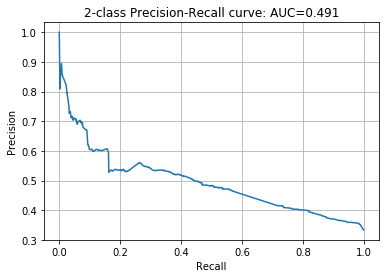

In [7]:
target = np.array([np.float32(t) for t in test[2]]).squeeze()
predictions = np.array(probs).squeeze()

average_precision = average_precision_score(target, predictions)
precision, recall, _ = precision_recall_curve(target, predictions)

plt.plot(recall, precision)

plt.grid()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('2-class Precision-Recall curve: AUC={0:0.3f}'.format(
          average_precision))
plt.show()

## Qualitative results

In [8]:
with session.as_default():
    skills = model.skill.eval()
users = dataset.get_users()

In [9]:
linuxutils.print_users_summary(skills, users, n=10)

### 10 most skilled users:
 1 +2.007 mcarlson@broadcom.com from broadcom (573 patches, 4 subsystems)
    rate: 87.6091%, main sub: drivers/net
 2 +1.942 rvossen@broadcom.com from broadcom (316 patches, 2 subsystems)
    rate: 90.1899%, main sub: drivers/staging
 3 +1.896 mchan@broadcom.com from broadcom (609 patches, 10 subsystems)
    rate: 84.2365%, main sub: drivers/net
 4 +1.892 frankyl@broadcom.com from broadcom (479 patches, 4 subsystems)
    rate: 89.1441%, main sub: drivers/staging
 5 +1.859 andrew.vasquez@qlogic.com from qlogic (538 patches, 4 subsystems)
    rate: 84.5725%, main sub: drivers/scsi
 6 +1.642 m.sujith@gmail.com from atheros (622 patches, 5 subsystems)
    rate: 79.4212%, main sub: drivers/net
 7 +1.538 eilong@broadcom.com from broadcom (277 patches, 4 subsystems)
    rate: 80.8664%, main sub: drivers/net
 8 +1.530 james.smart@emulex.com from emulex (253 patches, 2 subsystems)
    rate: 93.2806%, main sub: drivers/scsi
 9 +1.527 reinette.chatre@intel.com from lin

### Histograms of skills and difficulties

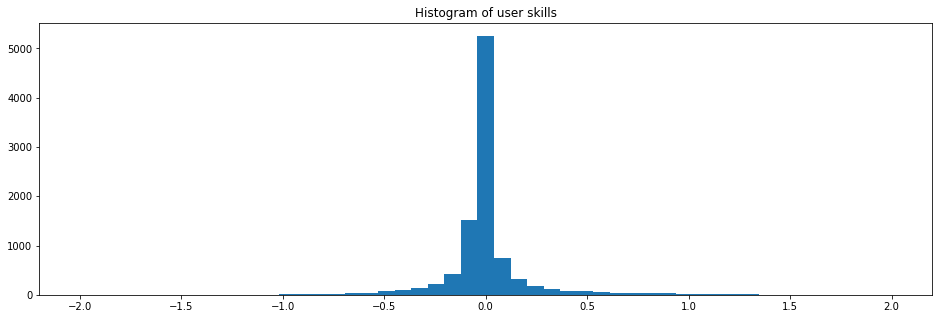

In [10]:
fig, ax1 = plt.subplots(ncols=1, figsize=(16, 5))

ax1.hist(skills, bins=np.linspace(-2, 2, num=50))
ax1.set_title("Histogram of user skills")

### Histograms of labels

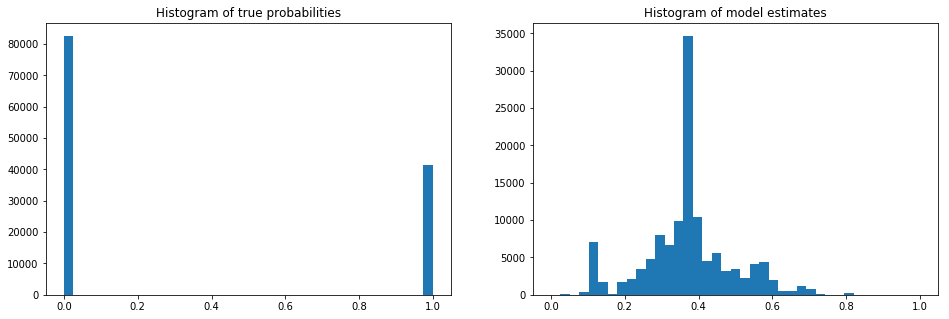

In [11]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 5), sharex=True)

ax1.hist(test[2], bins=np.linspace(0, 1, num=40))
ax1.set_title("Histogram of true probabilities")

ax2.hist(probs, bins=np.linspace(0, 1, num=40))
ax2.set_title("Histogram of model estimates")

In [12]:
saver = tf.train.Saver()
saver.save(session, "../trained-models/linux/useronly.ckpt")

with open('../data/linux-useronly-probs.txt', 'w') as f:
    f.writelines(['{:.20f}\n'.format(p) for p in probs[0]])